<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparation" data-toc-modified-id="Preparation-1">Preparation</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-2">Train</a></span><ul class="toc-item"><li><span><a href="#Balanced-classes" data-toc-modified-id="Balanced-classes-2.1">Balanced classes</a></span></li><li><span><a href="#Downsampling" data-toc-modified-id="Downsampling-2.2">Downsampling</a></span></li></ul></li><li><span><a href="#Selection-of-parameters" data-toc-modified-id="Selection-of-parameters-3">Selection of parameters</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-3.1">Logistic Regression</a></span></li><li><span><a href="#Linear-classifier-with-stochastic-gradient-descent" data-toc-modified-id="Linear-classifier-with-stochastic-gradient-descent-3.2">Linear classifier with stochastic gradient descent</a></span></li></ul></li><li><span><a href="#Test" data-toc-modified-id="Test-4">Test</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-4.1">Logistic Regression</a></span></li><li><span><a href="#Linear-classifier-with-stochastic-gradient-descent" data-toc-modified-id="Linear-classifier-with-stochastic-gradient-descent-4.2">Linear classifier with stochastic gradient descent</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-5">Conclusion</a></span><ul class="toc-item"><li><span><a href="#Final-result:" data-toc-modified-id="Final-result:-5.1">Final result:</a></span></li></ul></li></ul></div>

# Toxic comments

The online store launches a new service. Now users can edit and supplement product descriptions, just like in wiki communities. That is, clients propose their edits and comment on the changes of others. The store needs a tool to look for toxic comments and submit them for moderation.

Train the model to classify comments into positive and negative. At your disposal is a dataset with a markup on the toxicity of edits.

Build a model with a quality metric *F1* of at least 0.75.

**Instructions for the implementation of the project**

1. Download and prepare data.
2. Train different models.
3. Conclude.


**Data Description**

The data is in the `toxic_comments.csv` file. The *text* column contains the comment's text, and *toxic* is the target attribute.

## Preparation

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from matplotlib import rc

import re
#from pymystem3 import Mystem
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression, SGDClassifier

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the data
df = pd.read_csv('/datasets/toxic_comments.csv')

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

Let's study the data for gaps, types, see how they look.
</div>

In [3]:
df.info()
display(df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


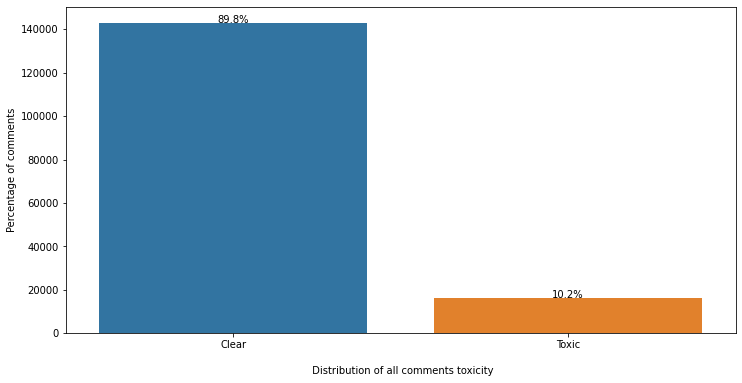

In [4]:
rcParams['figure.figsize'] = 12,6

def make_countplot(data, message, ax=None):
    try:
        if ax is None:
            ax = sns.countplot(data['toxic'])
        else:
            sns.countplot(data['toxic'], ax=ax)
    except:
        if ax is None:
            ax = sns.countplot(data)
        else:
            sns.countplot(data, ax=ax)
    ax.set_xlabel(f'\n Distribution of {message}', fontsize=10)
    ax.set_xticklabels(["Clear", "Toxic"], fontsize=10)
    ax.set_ylabel("Percentage of comments", fontsize=10)

    total = float(len(data))
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() - 0.4 + p.get_width()
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', fontsize=10)

    
make_countplot(df, 'all comments toxicity')

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

We see a clear imbalance of comments. Toxic comments make up around 10% of the total. This looks like accurate data, judging by the toxicity statistics of the comments.
    
The language of these comments is English. The next step is to lemmatize the text and remove unnecessary characters and signs that can prevent our model from learning from the data. For lemmatization, we use the <code>Mystem</code> morphological analyzer from the <code>pymystem3</code> library. To clean up, use the <code>re</code> module
    
After lemmatization and cleanup, we write the result in a new column <code>lemm_text</code> and delete the old <code>text</code>.
</div>

In [5]:
%%time

# Initialize Mystem
m  = WordNetLemmatizer()

# Define lemmatize_text function
def lemmatize_text(text):
    text = text.lower()
    lemm_text = "".join(m.lemmatize(text))
    cleared_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text) 
    return " ".join(cleared_text.split())

# Apply lemmatize_text function to 'text' column and create 'lemm_text' column
df['lemm_text'] = df['text'].apply(lemmatize_text)

# Drop 'text' column
df = df.drop(['text'], axis=1)

# Delete Mystem object
del m

df['lemm_text']

CPU times: user 7.09 s, sys: 140 ms, total: 7.23 s
Wall time: 7.48 s


0         explanation why the edits made under my userna...
1         d aww he matches this background colour i m se...
2         hey man i m really not trying to edit war it s...
3         more i can t make any real suggestions on impr...
4         you sir are my hero any chance you remember wh...
                                ...                        
159287    and for the second time of asking when your vi...
159288    you should be ashamed of yourself that is a ho...
159289    spitzer umm theres no actual article for prost...
159290    and it looks like it was actually you who put ...
159291    and i really don t think you understand i came...
Name: lemm_text, Length: 159292, dtype: object

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

To train the model, we will divide the dataset into three samples: Training (60%), Validation (20%), and Test (20%); this should be enough. Let's do so that the proportion of toxic and usual comments is preserved in the selections due to the <code>stratify</code> parameter.
Next, in the features, we will convert the lemmatized text to the Unicode type and arrange the weights using <code>TfidfVectorizer</code> and <code>nltk</code>. Let's display the dimension of the samples and build graphs to ensure that the distribution of comments is the same everywhere.
</div>

In [6]:
# Split the data into train, validation, and test sets
target = df['toxic']
features = df.drop(['toxic'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.3,
                                                                              stratify=target,
                                                                              random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            test_size=0.5,
                                                                            stratify=target_valid,
                                                                            random_state=12345)

In [7]:
# Create a TfidfVectorizer with specified stop words
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
%%time
# Transform the text data into TF-IDF vectors

features_train = count_tf_idf.fit_transform(features_train['lemm_text'].values.astype('U'))
features_valid = count_tf_idf.transform(features_valid['lemm_text'].values.astype('U'))
features_test = count_tf_idf.transform(features_test['lemm_text'].values.astype('U'))

CPU times: user 9.78 s, sys: 1.91 s, total: 11.7 s
Wall time: 11.7 s


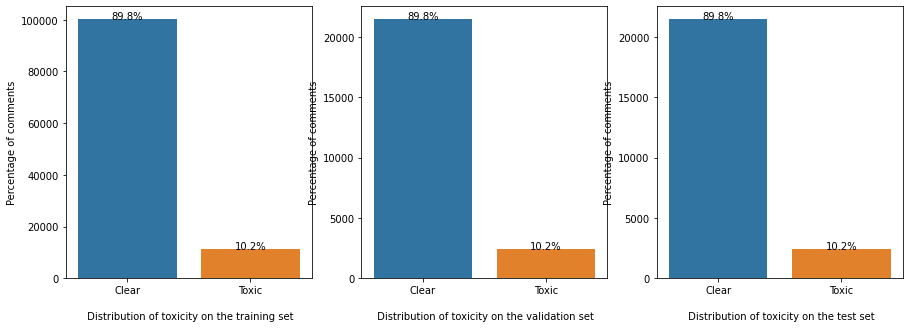

In [9]:
# Define the data and messages
target_list = [target_train, target_valid, target_test]
messages = ['toxicity on the training set', 'toxicity on the validation set', 'toxicity on the test set']

# Create a single row of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through each subplot and call make_countplot with the appropriate target and message
for i, ax in enumerate(axes):
    make_countplot(target_list[i], messages[i], ax=ax)

# Show the plot
plt.show()

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">
    
Distribution of toxic comments is consistent across all three sets. This indicates that the class imbalance is consistent throughout the different subsets of your data.
    
To decide on the choice of model, let's take a Logistic Regression model, cross-validate, and look at the parameter f1. Based on this result, we will decide whether the simplest model suits the problem.
</div>

In [10]:
# Create Pipeline
pipe_lr = Pipeline([('model', LogisticRegression())]) # Logistic Regression model

# Set model parameters
params = {
    'model__penalty': 'l2',  # Regularization type 
    'model__C': 1.0,  # Inverse regularization strength parameter
    'model__max_iter': 100,  # Maximum number of iterations
    'model__random_state': 12345  # Random seed for reproducibility
}

In [11]:
# Use stratified k-fold cross-validation to handle imbalanced data
cv = StratifiedKFold(n_splits=3, 
                     shuffle=True, 
                     random_state=12345)

# Train and evaluate the model using cross-validation with F1-score
scores = cross_val_score(pipe_lr, features_train, target_train, cv=cv, scoring='f1', n_jobs=-1)
train_f1 = scores.mean()

# Print the results
print("Average F1 Score: {:.2f}%".format(train_f1 * 100))

Average F1 Score: 68.77%


<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

We decided to use the Logistic Regression model for two reasons:

Without hyperparameter tuning, the model shows a relatively high f1 score.
The Logistic Regression model processes a large amount of information quickly. Other models such as decision trees or random forests may take longer, which is unacceptable for business needs. Since it's important to quickly respond to toxic comments and make decisions on moderation or banning users, speed is a crucial factor.
We will try three approaches to address the class imbalance issue:

Manually assigning class weights to the model.
Using the 'balanced' option in the class_weight parameter.
Performing downsampling of the majority class (zeros).
</div>

## Train

### Balanced classes

In [12]:
%%time

# Calculate the class ratio
class_ratio = df['toxic'].value_counts()[0] / df['toxic'].value_counts()[1]

# Create a dictionary with class weights
dict_classes={0:1, 1:class_ratio}

# Initialize a LR model with the class weights from dict_classes and perform cross-validation
model = LogisticRegression(class_weight=dict_classes)
train_f1_ballanced = cross_val_score(model, 
                                     features_train, 
                                     target_train, 
                                     cv=3, 
                                     scoring='f1').mean()
print(f'F1 for cross_val_score with balanced classes {train_f1_ballanced}')

F1 for cross_val_score with balanced classes 0.7552530301984671
CPU times: user 1min, sys: 1min 19s, total: 2min 19s
Wall time: 2min 20s


In [13]:
%%time
# Initialize a LR model with balanced classes and perform cross-validation
model = LogisticRegression(class_weight='balanced')
train_f1_balanced = cross_val_score(model, 
                                    features_train, 
                                    target_train, 
                                    cv=3, 
                                    scoring='f1').mean()
print(f'F1 на CV with balanced classes {train_f1_ballanced}')

F1 на CV with balanced classes 0.7552530301984671
CPU times: user 52 s, sys: 1min 9s, total: 2min 1s
Wall time: 2min 1s


<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">
Using balanced classes with two different approaches is not necessary, as the result is the same.

Let's perform resampling.
</div>

### Downsampling

In [14]:
# Create a new dataframe from the original one, selecting comments from the training dataset
df_train = df.iloc[target_train.index]

# Split into class 0 (non-toxic) and class 1 (toxic)
target_train_class_zero = df_train[df_train['toxic'] == 0]['toxic']
target_train_class_one = df_train[df_train['toxic'] == 1]['toxic']

In [15]:
%%time

# Take an equal number of class 0 and class 1 samples
target_train_class_zero_downsample = target_train_class_zero.sample(target_train_class_one.shape[0],
                                                                    random_state=12345)
# Concatenate them to create a balanced training dataset
target_train_downsample = pd.concat([target_train_class_zero_downsample, target_train_class_one])

# Select features from the original dataframe, using comments from the target
features_train_downsample = df.iloc[target_train_downsample.index]

# Shuffle the data thoroughly
features_train_downsample, target_train_downsample = shuffle(features_train_downsample,
                                                             target_train_downsample,
                                                             random_state=12345)
# Convert everything to unicode format, apply weights, and delete unnecessary variables
features_train_downsample = count_tf_idf.transform(features_train_downsample['lemm_text'].values.astype('U'))

del count_tf_idf
del stopwords

CPU times: user 1.38 s, sys: 280 ms, total: 1.66 s
Wall time: 1.69 s


<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

Let's take a look at the class balance.
</div>

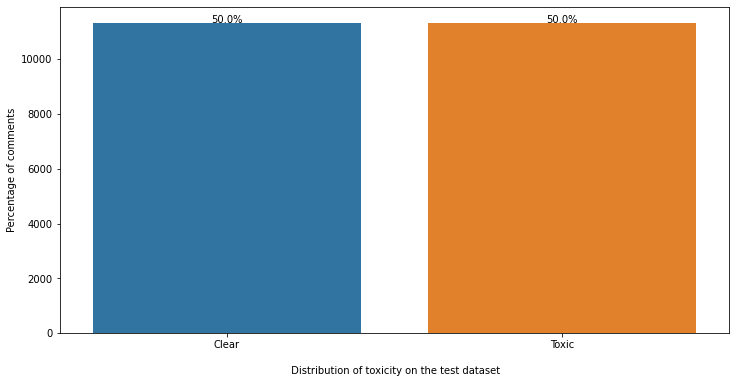

In [16]:
# Plot the countplot for the downsampled training dataset
make_countplot(target_train_downsample, 'toxicity on the test dataset')

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

It's time to perform cross-validation on the resampled training data and evaluate the F1 metric.
</div>

In [17]:
%%time
# Create a logistic regression model
model = LogisticRegression()

# Calculate the mean F1 score using cross-validation on the downsampled training dataset
train_f1_downsampled = cross_val_score(model,
                                       features_train_downsample, 
                                       target_train_downsample, 
                                       cv=3, 
                                       scoring='f1').mean()
print(f'F1 score on CV with class downsampling {train_f1_downsampled}')

F1 score on CV with class downsampling 0.8829960211460922
CPU times: user 23.1 s, sys: 32.4 s, total: 55.4 s
Wall time: 55.5 s


<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

Let's plot the ROC-AUC curve for three models:

- Logistic Regression
- Logistic Regression with balanced classes
- Logistic Regression with downsampled classes

</div>

In [18]:
# Create an empty dataframe to store the results
results = pd.DataFrame({'Model':[],
                        'F1 for CV' :[], 
                        'F1 for validation' : [], 
                        'AUC-ROC' : []})

# Define a function for calculating ROC-AUC scores and updating the results dataframe
def roc_auc(model,features_train,target_train,features_valid,target_valid,train_f1,name):
    
    # Fit the model on the training data
    model.fit(features_train, target_train)
    
    # Predict probabilities on the validation data
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    
    # Calculate the ROC curve and AUC-ROC score
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    
    # Calculate the F1 score on validation data
    valid_f1 = f1_score(target_valid, model.predict(features_valid))
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=name)
    
    # Update the results dataframe with the model performance metrics
    globals()['results'] = globals()['results'].append({
        'Model':name,
        'F1 for CV' : round(train_f1, 2),
        'F1 for validation' : round(valid_f1, 2), 
        'AUC-ROC' : round(auc_roc, 2)}, ignore_index=True)    

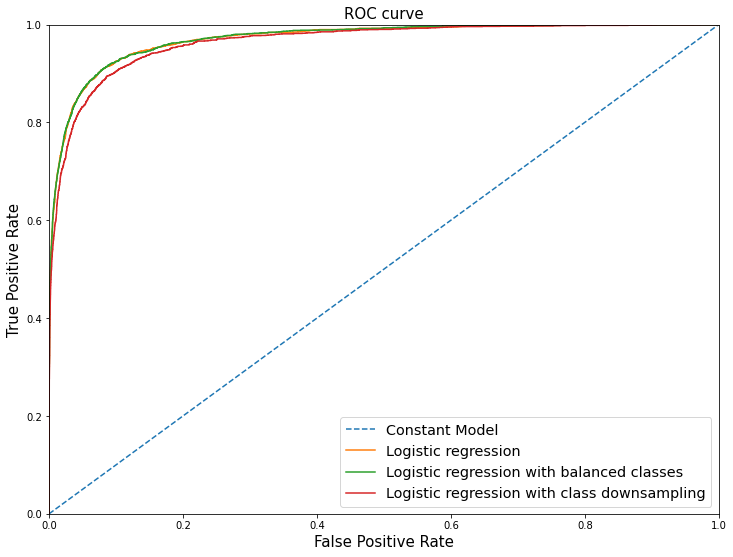

CPU times: user 50.4 s, sys: 1min 2s, total: 1min 53s
Wall time: 1min 53s


In [19]:
%%time

plt.figure(figsize=[12,9])

# Plot a dashed line to represent the constant model
plt.plot([0, 1], [0, 1], linestyle='--', label='Constant Model')

# Call the roc_auc() function with LogisticRegression() model and update the results dataframe
roc_auc(LogisticRegression(),
        features_train,target_train,
        features_valid,target_valid,
        train_f1,'Logistic regression')

# Call the roc_auc() function with LogisticRegression() model and class weights for balanced classes
# Update the results dataframe with the updated F1 score for balanced classes
roc_auc(LogisticRegression(class_weight=dict_classes),
        features_train,target_train,
        features_valid,target_valid,
        train_f1_balanced,'Logistic regression with balanced classes')

# Call the roc_auc() function with LogisticRegression() model and downsampled training data
# Update the results dataframe with the updated F1 score for downsampled classes
roc_auc(LogisticRegression(),
        features_train_downsample,target_train_downsample,
        features_valid,target_valid,
        train_f1_downsampled,'Logistic regression with class downsampling')

# Set the x-axis and y-axis limits to [0,1]
plt.xlim([0,1])
plt.ylim([0,1])

# Set x-axis and y-axis labels with font size 15
plt.xlabel("False Positive Rate", fontsize = 15)
plt.ylabel("True Positive Rate", fontsize = 15)

# Add a legend to the plot at the lower right corner with font size 'x-large'
plt.legend(loc='lower right', fontsize='x-large')

# Set the title of the plot with font size 15
plt.title("ROC curve", fontsize = 15)
plt.show()

# Set the 'Model' column as the index of the results dataframe
results.set_index('Model', inplace=True)

In [20]:
results

,F1 for CV,F1 for validation,AUC-ROC
Model,,,
Logistic regression,0.69,0.71,0.97
Logistic regression with balanced classes,0.75,0.77,0.97
Logistic regression with class downsampling,0.88,0.71,0.96


<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

Based on the results of training the Logistic Regression model with different class balances, the best data preprocessing option - class balancing - has been selected. Now we will fine-tune the hyperparameters more carefully and evaluate the model on the validation set. If successful, we will proceed to the test set, calculate the F1 score on the test set, and display the results on the ROC curve.
</div>

## Selection of parameters

### Logistic Regression

In [21]:
%%time

# Define the logistic regression model
model = LogisticRegression()

# Set the hyperparameter grid for grid search
params = [{'solver':['newton-cg', 'lbfgs', 'liblinear'],
           'C':[0.1, 1, 10],
           'class_weight':[dict_classes]}]

# Initialize GridSearchCV with LR model, hyperparameter grid, scoring metric, and cross-validation folds
clf = GridSearchCV(model, params, scoring='f1', cv=3)

# Fit the grid search to the training data
clf.fit(features_train, target_train)

# Get the best hyperparameters found by grid search
best_params = clf.best_params_

# Print the best hyperparameters
print("Best Hyperparameters: \n")
print(best_params, '\n')

# Calculate F1 score on cross-validation data
f1_cv = max(clf.cv_results_['mean_test_score'])

Best Hyperparameters: 

{'C': 10, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'lbfgs'} 

CPU times: user 5min 10s, sys: 6min 16s, total: 11min 27s
Wall time: 11min 29s


<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

As a result of hyperparameter tuning and cross-validation, the best model and its hyperparameters for the current task have been obtained. We will now train and evaluate this model on the validation set.
</div>

In [22]:
%%time

# Create a new logistic regression model with the best hyperparameters
model = LogisticRegression()
model.set_params(**best_params)

# Fit the model to the training data
model.fit(features_train, target_train)

# Predict target values for validation data
target_predict = model.predict(features_valid)

# Calculate F1 score on validation data
f1_valid = f1_score(target_valid, target_predict)

# Print F1 scores on cross-validation and validation data
print(f'F1 on cross-validation: {f1_cv}')
print(f'F1 on validation data: {f1_valid}')

F1 on cross-validation: 0.7641730227556615
F1 on validation data: 0.7758689572512985
CPU times: user 21.4 s, sys: 25 s, total: 46.4 s
Wall time: 46.5 s


<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

We have achieved an F1 score above 0.75, indicating that the model meets our expectations. There is a sufficient amount of data for prediction, and the model performs well on them. We can now proceed to testing.</div>

### Linear classifier with stochastic gradient descent

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

Let's consider another classification model. We will also specify balanced classes for it and fine-tune additional hyperparameters.

</div>

In [23]:
%%time

# Define the SGDClassifier model
sgdc = SGDClassifier()

# Set the hyperparameter grid for grid search
params = [{'loss':['hinge', 'log', 'modified_huber'],
           'learning_rate':['constant', 'optimal', 'invscaling', 'adaptive'],
           'eta0':[0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
           'random_state':[12345],
           'class_weight':[dict_classes]}]

# Initialize GridSearchCV with SGDClassifier model, hyperparameter grid, scoring metric, and cross-validation folds
clf = GridSearchCV(sgdc, params, scoring='f1', cv=3)

# Fit the grid search to the training data
clf.fit(features_train, target_train)

# Get the best hyperparameters found by grid search
sgdc_best_params = clf.best_params_

# Print the best hyperparameters
print("Best Hyperparameters: \n")
print(sgdc_best_params)

# Calculate F1 score on cross-validation data
sgdc_cv_f1 = max(clf.cv_results_['mean_test_score'])

Best Hyperparameters: 

{'class_weight': {0: 1, 1: 8.841344371679229}, 'eta0': 0.2, 'learning_rate': 'adaptive', 'loss': 'modified_huber', 'random_state': 12345}
CPU times: user 3min 20s, sys: 23.8 s, total: 3min 44s
Wall time: 3min 44s


In [24]:
%%time

# Create a new SGDClassifier model with the best hyperparameters
sgdc = SGDClassifier()
sgdc.set_params(**sgdc_best_params)

# Fit the model to the training data
sgdc.fit(features_train, target_train)

# Predict target values for validation data
target_predict = sgdc.predict(features_valid)

# Calculate F1 score on validation data
sgdc_valid_f1 = f1_score(target_valid, target_predict)

# Print F1 scores on cross-validation and validation data
print(f'F1 on cross-validation: {sgdc_cv_f1}')
print(f'F1 on validation data: {sgdc_valid_f1}')

F1 on cross-validation: 0.7586860805345363
F1 on validation data: 0.7670561628345269
CPU times: user 1.87 s, sys: 156 ms, total: 2.03 s
Wall time: 2.04 s


## Test

### Logistic Regression

Logistic Regression Metrics


,ROC AUC,F1,Precision,Recall,Accuracy
Logistic Regression,0.968227,0.76548,0.721898,0.814662,0.949276


Classification Report


,0,1,accuracy,macro avg,weighted avg
precision,0.978727,0.721898,0.949276,0.850313,0.952630
recall,0.964502,0.814662,0.949276,0.889582,0.949276
f1-score,0.971563,0.765480,0.949276,0.868521,0.950621
support,21466.000000,2428.000000,0.949276,23894.000000,23894.000000


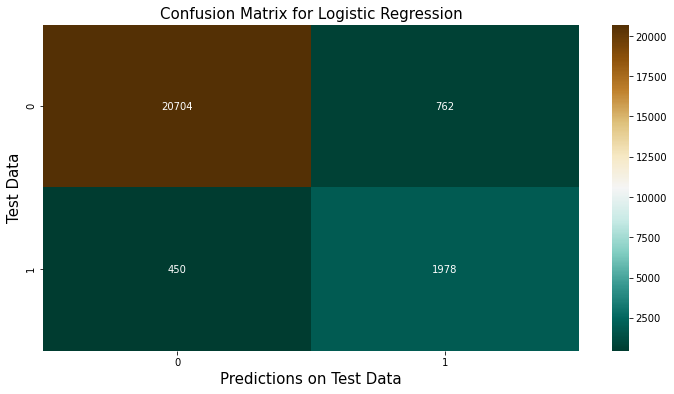

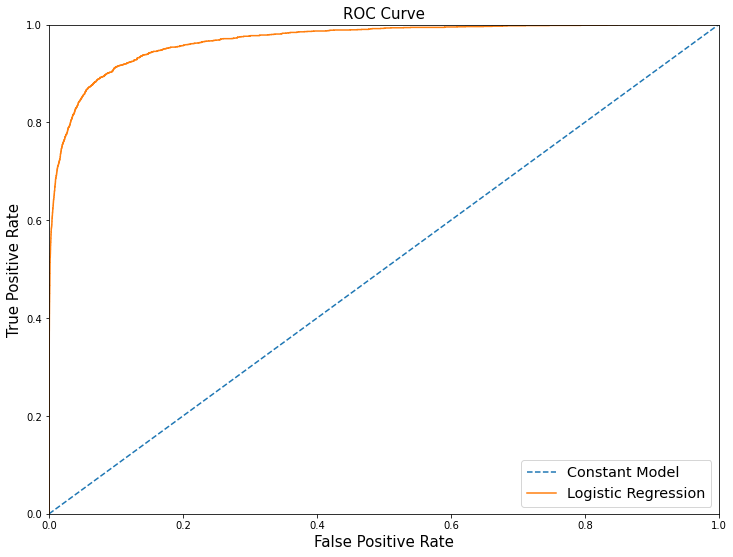

In [25]:
#lets create function for test

def test_func(model, name):
    # Predict probabilities for test data using the trained logistic regression model
    probabilities_test = model.predict_proba(features_test)

    # Extract probabilities of positive class (class 1)
    probabilities_one_test = probabilities_test[:, 1]

    # Calculate false positive rate, true positive rate, and thresholds for ROC curve
    fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

    # Predict target values for test data
    predict_test = model.predict(features_test)

    # Print metrics for logistic regression
    print(name,'Metrics')
    display(pd.DataFrame({'ROC AUC':[roc_auc_score(target_test, probabilities_one_test)],
                          'F1' :[f1_score(target_test, predict_test)], 
                          'Precision' : [precision_score(target_test, predict_test)], 
                          'Recall' : [recall_score(target_test, predict_test)],
                          'Accuracy' : [accuracy_score(target_test, predict_test)]}, index=[name]))

    # Print classification report
    print('Classification Report')
    display(pd.DataFrame(classification_report(target_test, predict_test, output_dict=True)))

    # Calculate confusion matrix
    cm = confusion_matrix(target_test, predict_test)

    # Create a heatmap of the confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap="BrBG_r")

    # Set labels and title for the heatmap
    plt.xlabel('Predictions on Test Data', fontsize = 15)
    plt.ylabel('Test Data', fontsize = 15)
    plt.title('Confusion Matrix for '+name, fontsize = 15)
    plt.show()
    
    return fpr, tpr, thresholds
    
# Func to plot Roc curve
def ROC_curve(fpr, tpr, name):
    # Create a plot for ROC curve
    plt.figure(figsize=[12,9])

    # Add a diagonal dotted line for the constant model
    plt.plot([0, 1], [0, 1], linestyle='--', label='Constant Model')

    # Set x and y limits for the plot
    plt.xlim([0,1])
    plt.ylim([0,1])

    # Plot the ROC curve for logistic regression
    plt.plot(fpr, tpr, label=name)

    # Set labels, legend, and title for the plot
    plt.xlabel("False Positive Rate", fontsize = 15)
    plt.ylabel("True Positive Rate", fontsize = 15)
    plt.legend(loc='lower right', fontsize='x-large')
    plt.title("ROC Curve", fontsize = 15)
    plt.show()
    
fpr, tpr, thresholds = test_func(model, 'Logistic Regression')
ROC_curve(fpr, tpr, 'Logistic Regression')

### Linear classifier with stochastic gradient descent

SGDClassifier Metrics


,ROC AUC,F1,Precision,Recall,Accuracy
SGDClassifier,0.972497,0.758557,0.685629,0.848847,0.945091


Classification Report


,0,1,accuracy,macro avg,weighted avg
precision,0.982430,0.685629,0.945091,0.834029,0.952270
recall,0.955977,0.848847,0.945091,0.902412,0.945091
f1-score,0.969023,0.758557,0.945091,0.863790,0.947636
support,21466.000000,2428.000000,0.945091,23894.000000,23894.000000


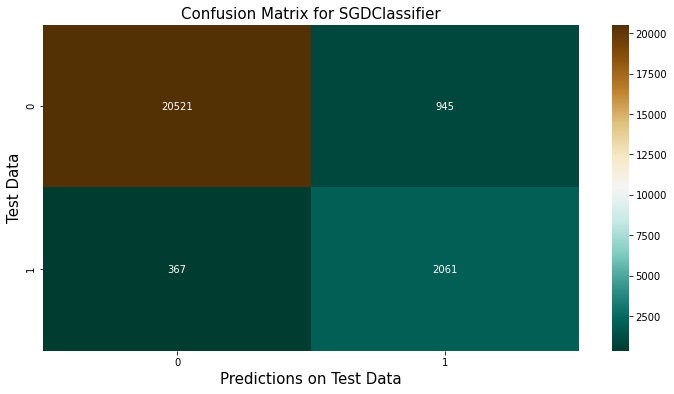

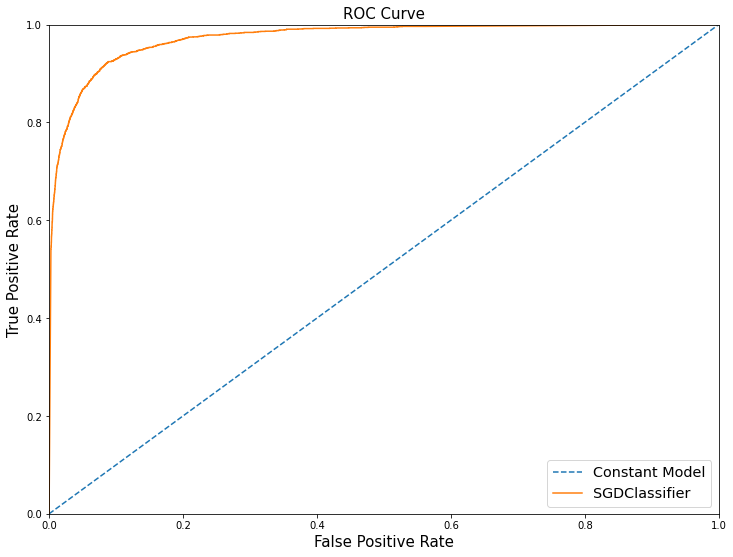

In [26]:
fpr, tpr, thresholds = test_func(sgdc, 'SGDClassifier')
ROC_curve(fpr, tpr, 'SGDClassifier')

## Conclusion

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

During the project, a successful model for predicting the toxicity of comments was built for the company.

Business objective: To learn to quickly respond to toxic comments from users and promptly intercept these comments/users.

The success of the model is evaluated based on the F1 metric.

<hr>
As a result of data analysis and preparation, the following was established and done:

The data consists of a dataset of over 150,000 English-language annotated comments. They are divided into 2 categories:
<blockquote>    
0 - Normal comment;<br>
1 - Toxic comment.
</blockquote> 
    
- The data does not contain missing values or outliers.
- Class distribution: 0 - 90%, 1 - 10%.
- Lemmatization of texts was performed.
- The data was divided into training, validation, and test sets (60/20/20).
- All texts were converted into vectors with specific weights and converted to Unicode type.
To address the class imbalance, 3 strategies were applied:

<blockquote>    
- No class imbalance handling;<br>
- Balanced classes handling.<br>
- Downsampling to the majority class.<br>
</blockquote>
As a result of cross-validation on the training set, the best strategy for handling class imbalance was found to be the model with balanced classes. However, validation on the validation set showed that the model with downsampled majority class performs better. The roc curve plot below shows that the model with balanced classes performs better on the validation set.
    
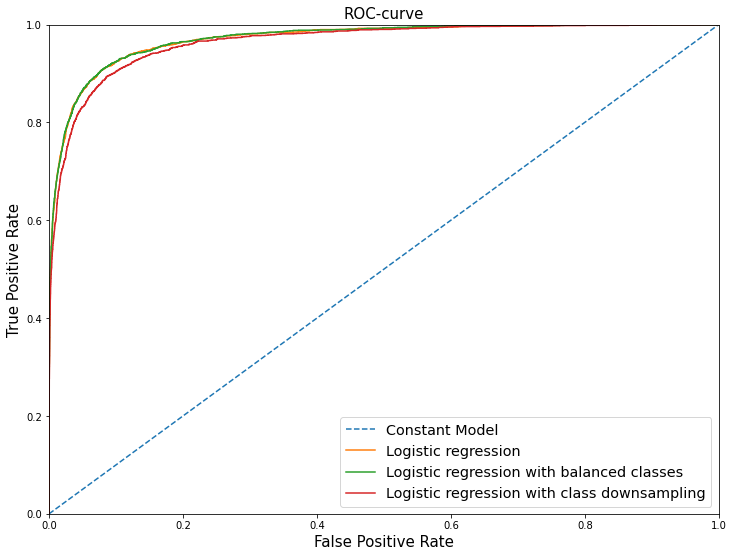
    
<hr>
    
GridSearchCV was used to tune hyperparameters for the Logistic Regression model on the test set.

During validation, our model with tuned hyperparameters showed an F1 score above 0.75.

<hr>
In the final testing stage, the Logistic Regression model achieved an F1 score of 0.763.
    
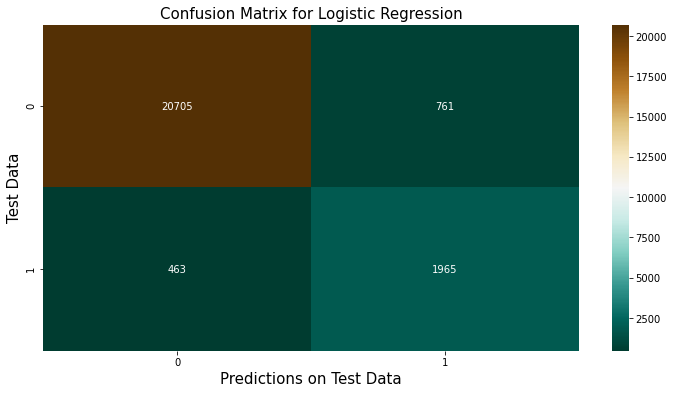
    
    
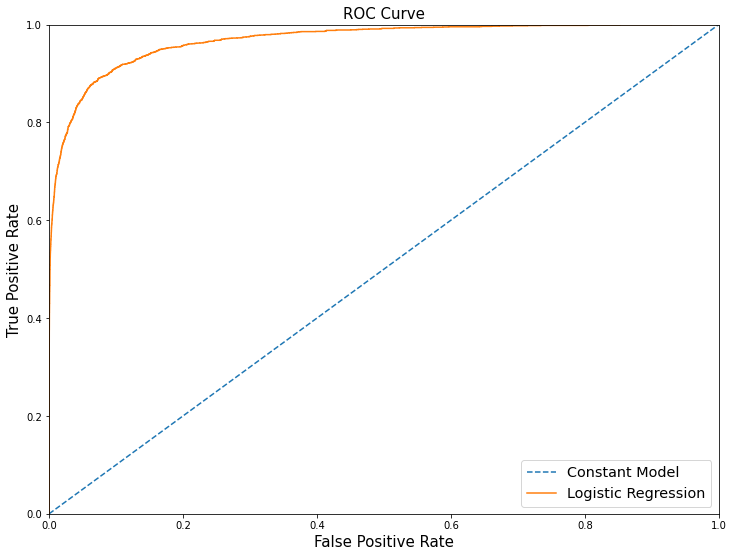

    
<hr>
    
A SGDClassifier model, which is a linear classifier with stochastic gradient descent, was also trained.

In the final testing stage, the model achieved an F1 score of 0.758.
    
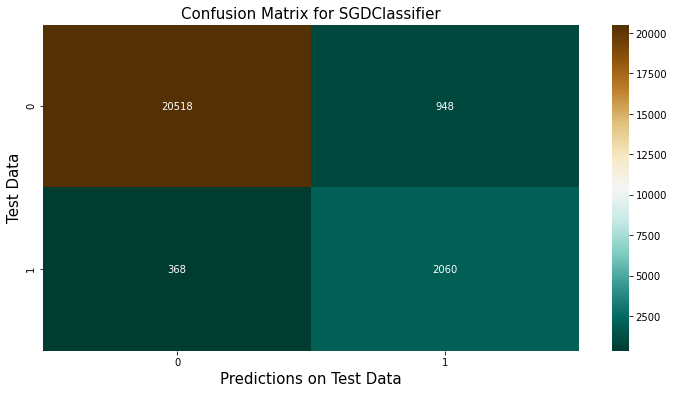    
    
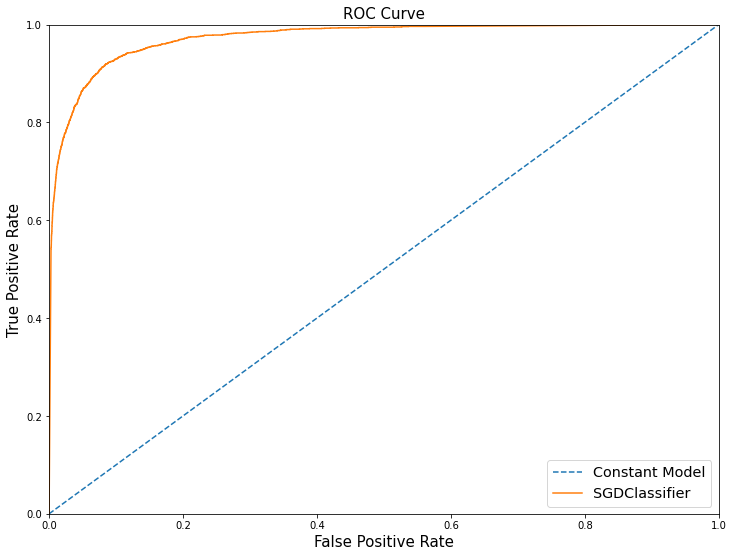  
    
<hr>
    
### Final result:
|Model|	F1 on Test|
    |:--|:--:|
|LogisticRegression|	0.7625|
|SGDClassifier|	0.7579|

    
</div>